# PSD decimation
In this notebook, we investigate the effect of decimation on noisy data. In frequency
domain, we assume the data in each bin to consist of signal plus noise,
$$d_i = h_i + n_i.$$
We assume the noise to be Gaussian, with a variance determined by the PSD,
$$n_i \sim \mathcal{N}\left(\mu_i = 0,
\,\sigma_i^2 = {\rm PSD}_i \cdot \hat{\sigma}^2
\right).$$
The power spectral density (PSD) is a property of the detector, and the term
$\hat{\sigma} = \sqrt{\frac{w}{4\Delta f}}$ (referred to as `noise_std` within dingo)
depends on the data conditioning, specifically on the window factor $w$ and the
frequency resolution $\Delta f$.

### Decimation
We decimate the GW data by averaging nearby frequency bins
$$\bar{d}_j = \frac{1}{N} \sum_{i = i_j}^{i_j + N - 1} \left(h_i + n_i\right)
= \bar{h}_j + \bar{n}_j,$$
where the decimated noise is given by a sum of $N$ gaussian random variables with
variances $\sigma_i^2$. The sum of $N$ gaussian random variables is normally distributed
$$
\bar{n}_j \sim \frac{1}{N}\mathcal{N}\left(\sum \mu_i,\, \sum \sigma_i^2\right)
= \mathcal{N}\left(\frac{\sum \mu_i}{N},\, \frac{\sum \sigma_i^2}{N^2}\right)
= \mathcal{N}\left(0,\, \frac{\sum \sigma_i^2}{N^2}\right).
$$
The noise variance of a bin in the decimated domain is thus given by
$$
\bar{\sigma}_j = \frac{1}{N^2} \sum {\rm PSD}_i \cdot \hat{\sigma}^2
= \frac{\hat{\sigma}^2}{N} \cdot \frac{\sum {\rm PSD}_i}{N}
= \frac{w}{4\Delta f\cdot N} \cdot \frac{\sum {\rm PSD}_i}{N}
= \frac{w}{4\Delta f_j\cdot} \cdot \overline{\rm PSD}_i
= \hat{\sigma}_j^2 \cdot \overline{\rm PSD}_i
$$
where we used that the frequency resolution in decimation band $j$ is related to the
frequency resolution of the base domain via
$$
\Delta f_j = \Delta f \cdot N.
$$
We can therefore simply decimate the PSD used for whitening in the same way as we
decimate the data, and adjust the `noise_std` $\hat{\sigma}_j$ for the updated
frequency resolution $\Delta f_j$.


In [1]:
from dingo.gw.domains import build_domain
domain_dict = {
    "type": "MultibandedFrequencyDomain",
    "bands": [
        [20.001953125, 20.462890625, 0.0078125],
        [20.474609375, 28.240234375, 0.015625],
        [28.263671875, 37.107421875, 0.03125],
        [37.154296875, 50.591796875, 0.0625],
        [50.685546875, 62.185546875, 0.125],
        [62.373046875, 114.623046875, 0.25],
        [114.998046875, 234.498046875, 0.5],
        [235.248046875, 389.248046875, 1.0],
        [390.748046875, 1022.748046875, 2.0],
    ],
    "base_domain": {
        "type": "FrequencyDomain",
        "f_min": 20.0,
        "f_max": 1024.0,
        "delta_f": 0.00390625,
        "window_factor": 1.0,
    }
}
mfd = build_domain(domain_dict)
ufd = mfd.base_domain

In [2]:
print(mfd.base_domain.delta_f)
print(mfd._delta_f_bands / mfd.decimation_inds_bands[:,-1])
print(mfd._delta_f_bands - (mfd.base_domain.delta_f * mfd.decimation_inds_bands[:,-1]))

0.00390625
[0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
from bilby.gw.detector import PowerSpectralDensity
from scipy.interpolate import interp1d
import numpy as np
psd = PowerSpectralDensity(asd_file="aLIGO_ZERO_DET_high_P_asd.txt")

In [4]:
psd_interp = interp1d(
    psd.frequency_array, psd.psd_array, bounds_error=False, fill_value=np.inf
)
psd_array_ufd = psd_interp(ufd.sample_frequencies)
psd_array_ufd = ufd.update_data(psd_array_ufd, low_value=1e-44)
asd_array_ufd = psd_array_ufd ** 0.5

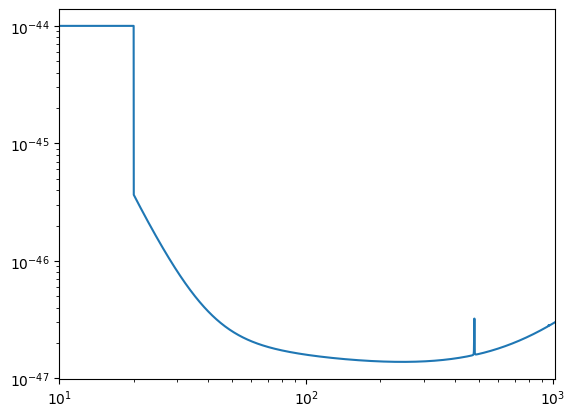

In [5]:
import matplotlib.pyplot as plt
plt.plot(mfd.base_domain(), psd_array_ufd)
plt.xlim((10, ufd.f_max))
plt.yscale("log")
plt.xscale("log")
plt.show()

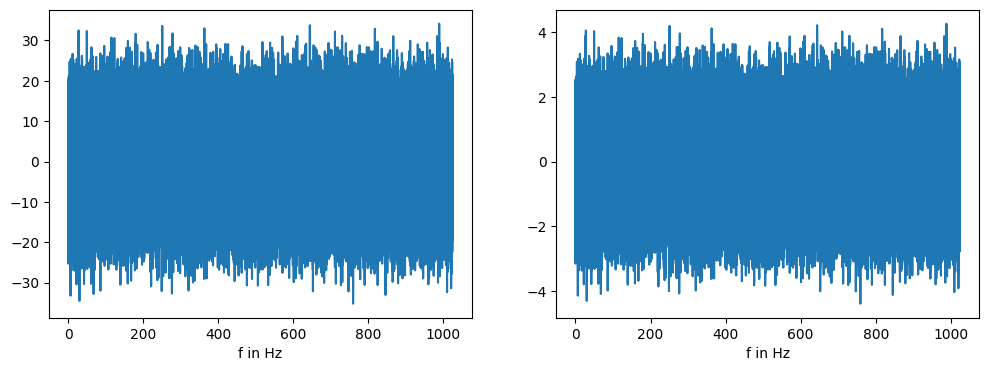

In [6]:
# generate noise, colored with this PSD
noise_ufd = (
    (np.random.randn(len(ufd)) + 1j * np.random.randn(len(ufd)))
    * asd_array_ufd
    * ufd.noise_std
)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(ufd(), noise_ufd.real / asd_array_ufd)
ax2.plot(ufd(), noise_ufd.real / (asd_array_ufd * ufd.noise_std))
ax1.set_xlabel("f in Hz")
ax2.set_xlabel("f in Hz")
plt.show()

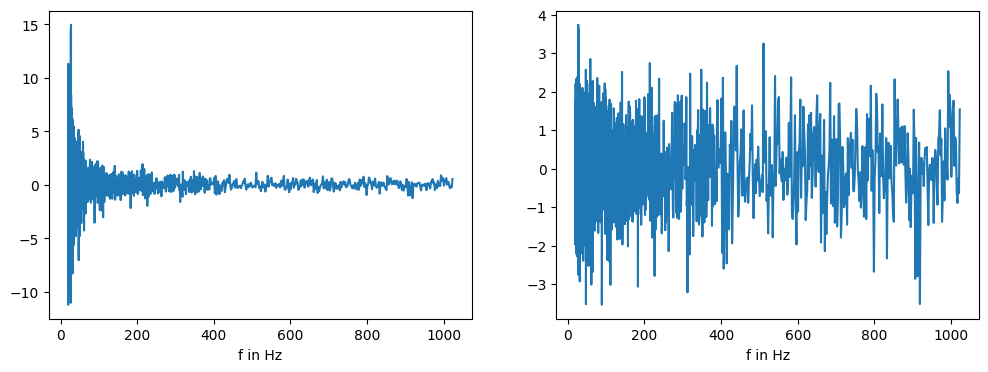

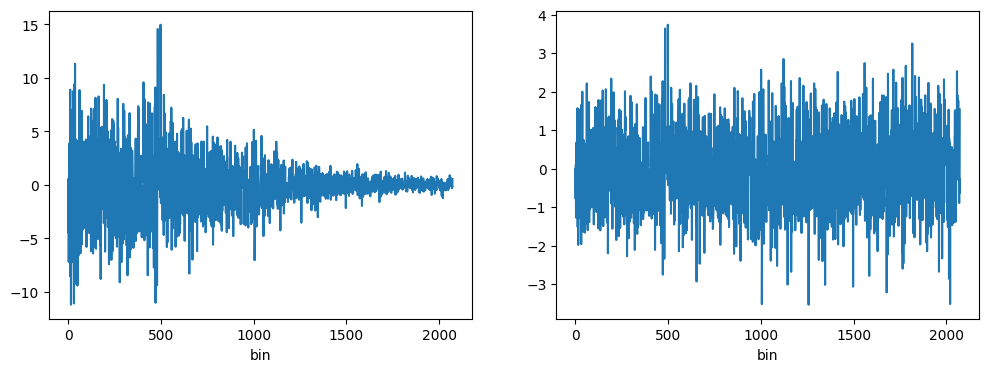

In [7]:
psd_array_mfd = mfd.decimate(psd_array_ufd)
asd_array_mfd = psd_array_mfd ** 0.5
noise_mfd = mfd.decimate(noise_ufd)
mfd_noise_std = np.sqrt(1.0) / np.sqrt(4.0 * mfd._delta_f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(mfd(), noise_mfd.real / asd_array_mfd)
ax2.plot(mfd(), noise_mfd.real / (asd_array_mfd * mfd_noise_std))
ax1.set_xlabel("f in Hz")
ax2.set_xlabel("f in Hz")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(noise_mfd.real / asd_array_mfd)
ax2.plot(noise_mfd.real / (asd_array_mfd * mfd_noise_std))
ax1.set_xlabel("bin")
ax2.set_xlabel("bin")
plt.show()

In [8]:
# check the noise std in each bin
noise_norm = noise_mfd / (asd_array_mfd * mfd_noise_std)
print(
    f"Noise std across all bands: {np.std(noise_norm.real):.3f} (real), "
    f"{np.std(noise_norm.imag):.3f} (imag).\n"
)
lower = 0
print("Band\t\tstd (real)\tstd (imag)")
for idx, upper in enumerate(np.cumsum(mfd._num_bins_bands)):
    # print(np.std(mfd._delta_f[lower:upper]))
    print(
        f"{idx}\t\t\t"
        f"{np.std(noise_norm[lower:upper].real):.3f}\t\t",
        f"{np.std(noise_norm[lower:upper].imag):.3f}",
    )
    lower = upper

Noise std across all bands: 0.993 (real), 0.999 (imag).

Band		std (real)	std (imag)
0			0.924		 1.063
1			0.978		 0.974
2			0.919		 1.001
3			1.014		 0.969
4			1.073		 0.975
5			1.010		 0.976
6			0.943		 0.947
7			1.024		 1.118
8			1.055		 1.021
